# QuickDraw Data

If machine learning is rocket science then data is your fuel! So before
doing anything we will have a close look at the data available and spend
some time bringing it into the "right" form (i.e.
[tf.train.Example](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/train/Example)).

That's why we start by spending quite a lot of time on this notebook, downloading
the data, understanding it, and transforming it into the right format for
Tensorflow.

The data used in this workshop is taken from Google's quickdraw (click on
the images to see loads of examples):

https://quickdraw.withgoogle.com/data

We will download the data below.

## Init

First, we'll choose where our data should be stored.

If you choose a path under **"/content/gdrive/My Drive"** then data will be stored in your Google drive and persisted across VM starts (preferrable).

In [0]:
data_path = '/content/gdrive/My Drive/amld_data'
# Alternatively, you can also store the data in a local directory. This method
# will also work when running the notebook in Jupyter instead of Colab.
# data_path = './amld_data'

In [0]:
if data_path.startswith('/content/gdrive/'):
  from google.colab import drive
  assert data_path.startswith('/content/gdrive/My Drive/'), \
         'Google Drive paths must start with "/content/gdrive/My Drive/"!'
  drive.mount('/content/gdrive')

if data_path.startswith('gs://'):
  from google.colab import auth
  auth.authenticate_user()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import base64, collections, io, itertools, functools, json, os, random, re, textwrap, time, urllib
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
from PIL import Image, ImageDraw
from IPython import display
from six.moves.urllib import request
from xml.dom import minidom

# Always make sure you are using running the expected version.
# There are considerable differences between versions...
# Tested with 1.12.0
tf.__version__

'1.12.0'

## Get the data

In this section we download a set of raw data files from the web.

In [0]:
# Retrieve list of categories.

def list_bucket(bucket, regexp='.*'):
    """Returns a (filtered) list of Keys in specified GCS bucket."""
    keys = []
    fh = request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')
print('available: (%d)' % len(all_ndjsons))
print('\n'.join(textwrap.wrap(
    '|'.join([key.split('/')[-1].split('.')[0] for key in all_ndjsons]),
    width=100)))

available: (309)
The Eiffel Tower|The Great Wall of China|The Mona Lisa|aircraft carrier|airplane|alarm
clock|ambulance|angel|animal
migration|ant|anvil|apple|arm|asparagus|axe|backpack|banana|bandage|barn|baseball bat|baseball|baske
t|basketball|bat|bathtub|beach|bear|beard|bed|bee|belt|bench|bicycle|binoculars|bird|birthday cake|b
lackberry|blueberry|book|boomerang|bottlecap|bowtie|bracelet|brain|bread|bridge|broccoli|broom|bucke
t|bulldozer|bus|bush|butterfly|cactus|cake|calculator|calendar|camel|camera|camouflage|campfire|cand
le|cannon|canoe|car|carrot|castle|cat|ceiling fan|cell
phone|cello|chair|chandelier|church|circle|clarinet|clock|cloud|coffee
cup|compass|computer|cookie|cooler|couch|cow|crab|crayon|crocodile|crown|cruise
ship|cup|diamond|dishwasher|diving board|dog|dolphin|donut|door|dragon|dresser|drill|drums|duck|dumb
bell|ear|elbow|elephant|envelope|eraser|eye|eyeglasses|face|fan|feather|fence|finger|fire
hydrant|fireplace|firetruck|fish|flamingo|flashlight|flip flops|fl

In [0]:
# Mini group of two animals.
pets = ['cat', 'dog']

# Somewhat larger group of zoo animals.
zoo = ['camel', 'crocodile', 'dolphin', 'elephant', 'flamingo', 'giraffe',
       'kangaroo', 'lion', 'monkey', 'penguin', 'rhinoceros']

# Even larger group of all animals.
animals = ['ant', 'bat', 'bear', 'bee', 'bird', 'butterfly', 'camel', 'cat',
           'cow', 'crab', 'crocodile', 'dog', 'dolphin', 'dragon', 'duck',
           'elephant', 'fish', 'flamingo', 'frog', 'giraffe', 'hedgehog',
           'horse', 'kangaroo', 'lion', 'lobster', 'monkey', 'mosquito',
           'mouse', 'octopus', 'owl', 'panda', 'parrot', 'penguin', 'pig',
           'rabbit', 'raccoon', 'rhinoceros', 'scorpion', 'sea turtle', 'shark',
           'sheep', 'snail', 'snake', 'spider', 'squirrel', 'swan']

Create your own group -- the more categories you include the more challenging the classification task will be...

In [0]:
# YOUR ACTION REQUIRED:
# Choose one of above groups for remainder of workshop.
# Note: This will result in ~100MB of download per class.
# The "dataset_name" will be used to construct directories containing the data.
labels, dataset_name = zoo, 'zoo'

In [0]:
# Download above chosen group.

def valid_ndjson(filename):
  """Checks presence + completeness of .ndjson file."""
  try:
    json.loads(tf.gfile.Open(filename).readlines()[-1])
    return True
  except (ValueError, IOError):
    return False

def retrieve(bucket, key, filename):
  """Returns a file specified by its Key from a GCS bucket."""
  url = 'https://storage.googleapis.com/%s/%s' % (
    bucket, urllib.parse.quote(key))
  print('\n' + url)
  if not tf.gfile.Exists(filename):
    with tf.gfile.Open(filename, 'w') as f:
      f.write(request.urlopen(url).read())
  while not valid_ndjson(filename):
    print('*** Corrupted download (%.2f MB), retrying...' % (os.path.getsize(filename) / 2.**20))
    with tf.gfile.Open(filename, 'w') as f:
      f.write(request.urlopen(url).read())

tf.gfile.MakeDirs(data_path)

print('\n%d labels:' % len(labels))

for name in labels:
  print(name, end=' ')
  dst = '%s/%s.ndjson' % (data_path, name)
  retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
  print('%.2f MB' % (tf.gfile.Stat(dst).length / 2.**20))

print('\nDONE :)')


11 labels:
camel 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/camel.ndjson
54.31 MB
crocodile 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/crocodile.ndjson
57.19 MB
dolphin 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/dolphin.ndjson
46.29 MB
elephant 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/elephant.ndjson
70.86 MB
flamingo 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/flamingo.ndjson
54.56 MB
giraffe 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/giraffe.ndjson
58.27 MB
kangaroo 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/kangaroo.ndjson
96.06 MB
lion 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/lion.ndjson
90.47 MB
monkey 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/monkey.ndjson
91.05 MB
penguin 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/penguin.ndjson
137.90 MB
rhinocero

## Inspect the data

Let's find out what the format of the downloaded files is.

First, we are going to enumerate them.

In [0]:
print('\n'.join([
    '%6.1fM : %s' % (tf.gfile.Stat(path).length/1024**2, path)
    for path in tf.gfile.Glob('{}/*.ndjson'.format(data_path))
]))

  54.3M : /content/gdrive/My Drive/amld_data/camel.ndjson
  57.2M : /content/gdrive/My Drive/amld_data/crocodile.ndjson
  46.3M : /content/gdrive/My Drive/amld_data/dolphin.ndjson
  70.9M : /content/gdrive/My Drive/amld_data/elephant.ndjson
  54.6M : /content/gdrive/My Drive/amld_data/flamingo.ndjson
  58.3M : /content/gdrive/My Drive/amld_data/giraffe.ndjson
  96.1M : /content/gdrive/My Drive/amld_data/kangaroo.ndjson
  90.5M : /content/gdrive/My Drive/amld_data/lion.ndjson
  91.1M : /content/gdrive/My Drive/amld_data/monkey.ndjson
 137.9M : /content/gdrive/My Drive/amld_data/penguin.ndjson
  92.2M : /content/gdrive/My Drive/amld_data/rhinoceros.ndjson


Let's further explore what the `NDJSON` file format is.

In [0]:
path = sorted(tf.gfile.Glob(os.path.join(data_path, '*.ndjson')))[0]
print(tf.gfile.Open(path).read()[:1000] + '...')

{"word":"camel","countrycode":"AU","timestamp":"2017-03-09 09:13:23.70821 UTC","recognized":true,"key_id":"4652244525907968","drawing":[[[47,27,15,3,0,2,12,33,46,51,53,49,40],[0,4,11,25,38,51,58,57,48,40,27,17,8]],[[49,60,66,74,90,105,116,125,132,141,151,160,172,183,190,199,221,232,229,218,198,182,142,109,95,52,37,26],[44,60,63,59,36,33,44,69,73,65,38,33,36,54,77,83,88,106,121,136,149,155,154,143,136,101,79,49]],[[229,245,253,255,249],[95,105,114,131,169]],[[63,45,44,48],[99,155,171,172]],[[42,62,76],[161,162,120]],[[97,89,90,95,106,112,113],[130,152,165,170,171,164,139]],[[151,149,151,155,163],[153,159,170,176,179]]]}
{"word":"camel","countrycode":"PH","timestamp":"2017-01-26 03:02:58.05583 UTC","recognized":true,"key_id":"4641031645560832","drawing":[[[62,63,72,82,98,109,123,130,136],[77,59,39,24,16,18,31,59,68]],[[63,15,2,0,3,26,38,66,100,152,174,177,172,161,137],[79,86,97,107,114,131,134,139,136,115,95,81,71,67,65]],[[41,40,28],[137,170,255]],[[67,60,62],[140,209,240]],[[125,138,13

As we can see, it's a format that contains one JSON dictionary per line.

Let's parse one single line.

In [0]:
data_json = json.loads(tf.gfile.Open(path).readline())
data_json.keys()

dict_keys(['word', 'countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])

In [0]:
# So we have some meta information...
for k, v in data_json.items():
  if k != 'drawing':
    print('%20s   ->   %s' % (k, v))

                word   ->   camel
         countrycode   ->   AU
           timestamp   ->   2017-03-09 09:13:23.70821 UTC
          recognized   ->   True
              key_id   ->   4652244525907968


In [0]:
# ...and the actual drawing.
drawing = data_json['drawing']
# The drawing consists of a series of strokes:
print('Shapes:', [np.array(stroke).shape for stroke in drawing])
print('Example stroke:', drawing[0])

Shapes: [(2, 13), (2, 28), (2, 5), (2, 4), (2, 3), (2, 7), (2, 5)]
Example stroke: [[47, 27, 15, 3, 0, 2, 12, 33, 46, 51, 53, 49, 40], [0, 4, 11, 25, 38, 51, 58, 57, 48, 40, 27, 17, 8]]


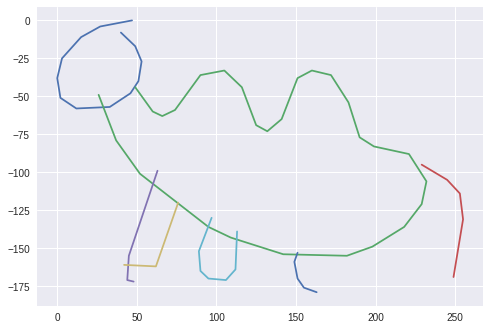

In [0]:
# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:
for stroke in drawing:
  # Each array has X coordinates at [0, :] and Y coordinates at [1, :].
  pyplot.plot(np.array(stroke[0]), -np.array(stroke[1]))
# Would YOU recognize this drawing successfully?

In [0]:
# Some more code to load many sketches at once.
# Let's ignore the difficult "unrecognized" sketches for now...
# (i.e. unrecognized by the official quickdraw classifier)

def convert(line):
    """Converts single JSON line and converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d

def loaditer(name, unrecognized=False):
  """Returns iterable of drawings in specified file.

  Args:
    name: Name of the downloaded object (e.g. "elephant").
    unrecognized: Whether to include drawings that were not recognized
        by Google AI (i.e. the hard ones).
  """
  for line in tf.gfile.Open('%s/%s.ndjson' % (data_path, name)):
    d = convert(line)
    if d['recognized'] or unrecognized:
      yield d

def loadn(name, n, unrecognized=False):
  """Returns list of drawings.

  Args:
    name: Name of the downloaded object (e.g. "elephant").
    n: Number of drawings to load.
    unrecognized: Whether to include drawings that were not recognized
        by Google AI (i.e. the hard ones).
  """
  it = loaditer(name, unrecognized=unrecognized)
  return list(itertools.islice(it, 0, n))

n = 100
print('Loading {} instances of "{}"...'.format(n, labels[0]), end='')
sample = loadn(labels[0], 100)
print('done.')

Loading 100 instances of "camel"...done.


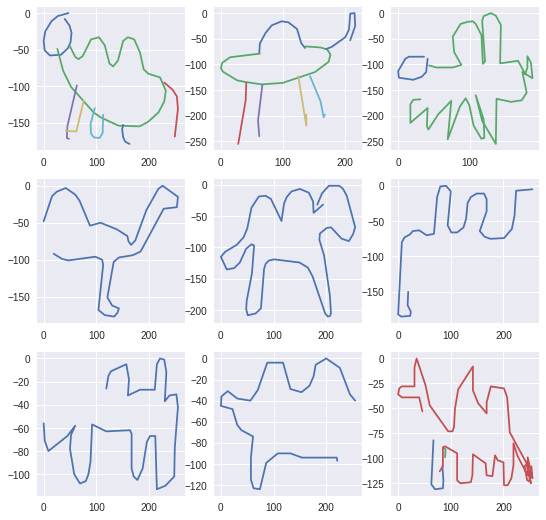

In [0]:
# Some more drawings...
rows, cols = 3, 3
pyplot.figure(figsize=(3*cols, 3*rows))
for y in range(rows):
  for x in range(cols):
    i = y * cols + x
    pyplot.subplot(rows, cols, i + 1)
    for stroke in sample[i]['drawing']:
      pyplot.plot(np.array(stroke[0]), -np.array(stroke[1]))

## Rasterize

Idea: After converting the raw drawing data into rasterized images, we can
use [MNIST](https://www.tensorflow.org/get_started/mnist/beginners)-like
image processing to classify the drawings.

In [0]:
def dict_to_img(drawing, img_sz=64, lw=3, maximize=True):
  """Converts QuickDraw data to quadratic rasterized image.
  
  Args:
    drawing: Dictionary instance of QuickDraw dataset.
    img_sz: Size output image (in pixels).
    lw: Line width (in pixels).
    maximize: Whether to maximize drawing within image pixels.
    
  Returns:
    A PIL.Image with the rasterized drawing.
  """
  img = Image.new('L', (img_sz, img_sz))
  draw = ImageDraw.Draw(img)
  lines = np.array([
      stroke[0:2, i:i+2]
      for stroke in drawing['drawing']
      for i in range(stroke.shape[1] - 1)
  ], dtype=np.float32)
  if maximize:
    for i in range(2):
      min_, max_ = lines[:,i,:].min() * 0.95, lines[:,i,:].max() * 1.05
      lines[:,i,:] = (lines[:,i,:] - min_) / max(max_ - min_, 1)
  else:
    lines /= 1024
  for line in lines:
    draw.line(tuple(line.T.reshape((-1,)) * img_sz), fill='white', width=lw)
  return img


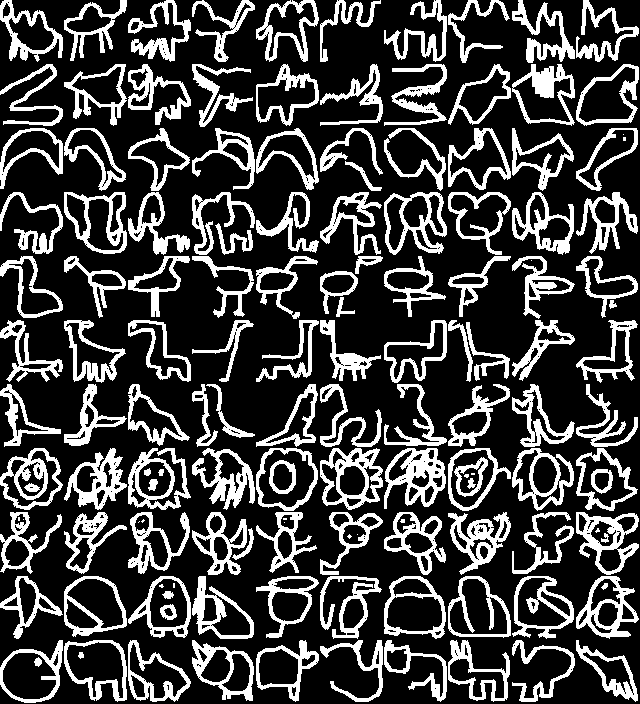

10 samples of : camel crocodile dolphin elephant flamingo giraffe kangaroo lion monkey penguin rhinoceros


In [0]:
# Show some examples.

def showimg(img):
  """Shows an image with an inline HTML <img> tag.
  
  Args:
    img: Can be a PIL.Image or a numpy.ndarray.
  """
  if isinstance(img, np.ndarray):
    img = Image.fromarray(img, 'L')
  b = io.BytesIO()
  img.convert('RGB').save(b, format='png')
  enc = base64.b64encode(b.getvalue()).decode('utf-8')
  display.display(display.HTML(
      '<img src="data:image/png;base64,%s">' % enc))

# Fetch some images + shuffle order.
rows, cols = len(labels), 10
n_per_class = rows * cols // len(labels) + 1
drawings_list = [drawing for name in labels
                 for drawing in loadn(name, cols)]

# Create mosaic of rendered images.
lw = 4
img_sz = 64
tableau = np.zeros((img_sz * rows, img_sz * cols), dtype=np.uint8)
for y in range(rows):
  for x in range(cols):
    i = y * cols + x
    img = dict_to_img(drawings_list[i], img_sz=img_sz, lw=lw, maximize=True)
    tableau[y*img_sz:(y+1)*img_sz,
            x*img_sz:(x+1)*img_sz] = np.asarray(img)

showimg(tableau)
print('{} samples of : {}'.format(cols, ' '.join(labels)))

## Protobufs and tf.train.Example

Tensorflow's "native" format for data storage is the `tf.train.Example`
[protocol buffer](https://en.wikipedia.org/wiki/Protocol_Buffers).

In this section we briefly explore the API needed to access the data
inside the `tf.train.Example` protocol buffer. It's **not necessary** to read
through the
[Protocol Buffer Basics: Python - documentation](https://developers.google.com/protocol-buffers/docs/pythontutorial).

In [0]:
# Create a new (empty) instance.
example = tf.train.Example()
# (empty example will print nothing)
print(example)
# An example contains a map from feature name to "Feature".
# Every "Feature" contains a list of elements of the same
# type, which is one of:
# - bytes_list (similar to Python's "str")
# - float_list (float number)
# - int64_list (integer number)

# These values can be accessed as follows (no need to understand
# details):

# Add float value "3.1416" to feature "magic_numbers"
example.features.feature['magic_numbers'].float_list.value.append(3.1416)
# Add some more values to the float list "magic_numbers".
example.features.feature['magic_numbers'].float_list.value.extend([2.7183, 1.4142, 1.6180])

### YOUR ACTION REQUIRED:
# Create a second feature named "adversaries" and add the elements
# b'Alice' and b'Bob'.
example.features.feature['adversaries'].bytes_list.value.extend([b'Alice', b'Bob']) #example.features.feature['adversaries'].

# This will now print a serialized representation of our protocol buffer
# with features "magic_numbers" and "adversaries" set...
print(example)

# .. et voila : that's all you need to know about protocol buffers
# for this workshop.


features {
  feature {
    key: "adversaries"
    value {
      bytes_list {
        value: "Alice"
        value: "Bob"
      }
    }
  }
  feature {
    key: "magic_numbers"
    value {
      float_list {
        value: 3.1415998935699463
        value: 2.7183001041412354
        value: 1.414199948310852
        value: 1.6180000305175781
      }
    }
  }
}



## Create datasets

Now let's create a "dataset" of `tf.train.Example`
[protocol buffers](https://developers.google.com/protocol-buffers/) ("protos").

A single example will containt all the information we want to use for training for a drawing (i.e. rasterized
image, label, and maybe other information).

A dataset consists of non-overlapping sets of examples that will be used for
training and evaluation of the classifier (the "test" set will be used for the
final evaluation). Because these files can quickly become very large, we
"shard" them into multiple smaller files of equal size.

In [0]:
# Let's first check how many [recognized=True] examples we have in each class.
for name in labels:
    print(name, len(list(tf.gfile.Open('%s/%s.ndjson' % (data_path, name)))), 'recognized', len(list(loaditer(name))))

camel 121399 recognized 115454
crocodile 127932 recognized 106410
dolphin 121613 recognized 110335
elephant 126969 recognized 104986
flamingo 124569 recognized 116251
giraffe 127182 recognized 122396
kangaroo 174470 recognized 152511
lion 120949 recognized 98976
monkey 127633 recognized 105650
penguin 253791 recognized 231826
rhinoceros 188484 recognized 166539


In [0]:
# Helper code to create sharded recordio files.
# (No need to read through this.)

# Well... Since you continue to read through this cell, I could as
# well explain in more detail what it is about :-)
# Because we work with large amounts of data, we will create "sharded"
# files, that is, we split a single dataset into a number of files, like
# train-00000-of-00004, ..., train-00000-of-00005 (if we're using 5 shards).
# This way we have smaller individual files, and we can also easily access
# e.g. 20% of all data, or have 5 threads reading through the data
# simultaneously. With large datasets, try to shard data into individual files
# ~ 100 MB.

# The code in this cell simply takes a list of iterators and then
# randomly distributes the values returned by these iterators into sharded
# datasets (e.g. a train/eval/test split).

def rand_key(counts):
  """Returns a random key from "counts", using values as distribution."""
  r = random.randint(0, sum(counts.values()))
  for key, count in counts.items():
    if r > count or count == 0:
      r -= count
    else:
      counts[key] -= 1
      return key

def get_split(i, splits):
  """Returns key from "splits" for iteration "i"."""
  i %= sum(splits.values())
  for split in sorted(splits):
    if i < splits[split]:
      return split
    i -= splits[split]

def make_counts(labels, total):
  """Generates counts for "labels" totaling "total"."""
  counts = {}
  for i, name in enumerate(labels):
    counts[name] = total // (len(labels) - i)
    total -= counts[name]
  return counts

def example_to_dict(example):
  """Converts a tf.train.Example to a dictionary."""
  example_dict = {}
  for name, value in example.features.feature.items():
    if value.HasField('bytes_list'):
      value = value.bytes_list.value
    elif value.HasField('int64_list'):
      value = value.int64_list.value
    elif value.HasField('float_list'):
      value = value.float_list.value
    else:
      raise 'Unknown *_list type!'
    if len(value) == 1:
      example_dict[name] = value[0]
    else:
      example_dict[name] = np.array(value)
  return example_dict

def make_sharded_files(make_example, path, labels, iters, counts, splits,
                       shards=10, overwrite=False, report_dt=10, make_df=False):
  """Create sharded dataset from "iters".

  Args:
    make_example: Converts object returned by elements of "iters"
        to tf.train.Example() proto.
    path: Directory that will contain recordio files.
    labels: Names of labels, will be written to "labels.txt".
    iters: List of iterables returning drawing objects.
    counts: Dictionary mapping class to number of examples.
    splits: Dictionary mapping filename to multiple of examples. For example,
        splits=dict(a=2, b=1) will result in two exampels being written to "a"
        for every example being written to "b".
    shards: Number of files to be created per split.
    overwrite: Whether a pre-existing directory should be overwritten.
    report_dt: Number of seconds between status updates (0=no updates).
    make_df: Also write data as pandas.DataFrame - do NOT use this with very
        large datasets that don't fit in memory!

  Returns:
    Total number of examples written to disk per split.
  """
  assert len(iters) == len(labels)
  # Prepare output.
  if not os.path.exists(path):
    os.makedirs(path)
  paths = {
      split: ['%s/%s-%05d-of-%05d' % (path, split, i, shards)
              for i in range(shards)]
      for split in splits
  }
  assert overwrite or not os.path.exists(paths.values()[0][0])
  writers = {
      split: [tf.python_io.TFRecordWriter(ps[i]) for i in range(shards)]
      for split, ps in paths.items()
  }
  t0 = time.time()
  examples_per_split = collections.defaultdict(int)
  i, n = 0, sum(counts.values())
  counts = dict(**counts)
  rows = []
  # Create examples.
  while sum(counts.values()):
    name = rand_key(counts)
    split = get_split(i, splits)
    writer = writers[split][examples_per_split[split] % shards]
    label = labels.index(name)
    example = make_example(label, next(iters[label]))
    writer.write(example.SerializeToString())
    if make_df:
      example.features.feature['split'].bytes_list.value.append(split.encode('utf8'))
      rows.append(example_to_dict(example))
    examples_per_split[split] += 1
    i += 1
    if report_dt > 0 and time.time() - t0 > report_dt:
      print('processed %d/%d (%.2f%%)' % (i, n, 100. * i / n))
      t0 = time.time()
  # Store results.
  for split in splits:
    for writer in writers[split]:
      writer.close()
  with open('%s/labels.txt' % path, 'w') as f:
    f.write('\n'.join(labels))
  with open('%s/counts.json' % path, 'w') as f:
    json.dump(examples_per_split, f)
  if make_df:
    df_path = '%s/dataframe.pkl' % path
    print('Writing %s...' % df_path)
    pd.DataFrame(rows).to_pickle(df_path)
  return dict(**examples_per_split)

### Create IMG dataset

In [0]:
# Uses dict_to_img() from previous cell to create raster image.

def make_example_img(label, drawing):
  """Converts QuickDraw dictionary to example with rasterized data.

  Args:
    label: Numerical representation of the label (e.g. "0" for labels[0]).
    drawing: Dictionary with QuickDraw data.

  Returns:
    A tf.train.Example protocol buffer (with "label", "img_64", and additional
    metadata features).
  """
  example = tf.train.Example()
  example.features.feature['label'].int64_list.value.append(label)
  img_64 = np.asarray(dict_to_img(drawing, img_sz=64, lw=4, maximize=True)).reshape(-1)
  example.features.feature['img_64'].int64_list.value.extend(img_64)
  example.features.feature['countrycode'].bytes_list.value.append(drawing['countrycode'].encode())
  example.features.feature['recognized'].int64_list.value.append(drawing['recognized'])
  example.features.feature['word'].bytes_list.value.append(drawing['word'].encode())
  ts = drawing['timestamp']
  ts = time.mktime(time.strptime(ts[:ts.index('.')], '%Y-%m-%d %H:%M:%S'))
  example.features.feature['timestamp'].int64_list.value.append(int(ts))
  example.features.feature['key_id'].int64_list.value.append(int(drawing['key_id']))
  return example

In [0]:
# Create the (rasterized) dataset.

path = '%s/%s_img' % (data_path, dataset_name)
t0 = time.time()
examples_per_split = make_sharded_files(
    make_example=make_example_img,
    path=path,
    labels=labels,
    iters=[loaditer(name) for name in labels],
    # Creating 50k train, 10k eval, 20k test examples. Takes ~2min
    # Note : Larger datasets take longer to generate and to train on, but
    #        also lead to better classification results.
    counts=make_counts(labels, 80000),
    splits=dict(train=5, eval=1, test=2),
    overwrite=True,
    # Note : Set this to False when generating large datasets...
    make_df=True,
)

### If you don't see the final output below, it's probably because your VM
### has run out of memory and crashed !! This can happen with make_df=True ...

print('stored data to "%s"' % path)
print('generated %s examples in %d seconds' % (examples_per_split, time.time() - t0))

processed 3796/80000 (4.75%)
processed 7163/80000 (8.95%)
processed 10911/80000 (13.64%)
processed 14693/80000 (18.37%)
processed 18462/80000 (23.08%)
processed 22263/80000 (27.83%)
processed 26054/80000 (32.57%)
processed 29844/80000 (37.30%)
processed 33597/80000 (42.00%)
processed 37341/80000 (46.68%)
processed 41120/80000 (51.40%)
processed 44912/80000 (56.14%)
processed 48695/80000 (60.87%)
processed 52507/80000 (65.63%)
processed 56322/80000 (70.40%)
processed 60148/80000 (75.19%)
processed 63979/80000 (79.97%)
processed 67810/80000 (84.76%)
processed 71615/80000 (89.52%)
processed 75437/80000 (94.30%)
processed 79245/80000 (99.06%)
Writing /content/gdrive/My Drive/amld_data/zoo_img/dataframe.pkl...
stored data to "/content/gdrive/My Drive/amld_data/zoo_img"
generated {'eval': 10000, 'test': 20000, 'train': 50000} examples in 367 seconds


### Create STROKE dataset

This section creates another dataset of example protos that contain the raw
stroke data, suitable for usage with a recurrent neural network.

In [0]:
# Convert stroke coordinates into normalized relative coordinates,
# one single list, and add a "third dimension" that indicates when
# a new stroke starts.

def dict_to_stroke(d):
  norm = lambda x: (x - x.min()) / max(1, (x.max() - x.min()))
  xy = np.concatenate([np.array(s, dtype=np.float32) for s in d['drawing']], axis=1)
  z = np.zeros(xy.shape[1])
  if len(d['drawing']) > 1:
    z[np.cumsum(np.array(list(map(lambda x: x.shape[1], d['drawing'][:-1]))))] = 1
  dxy = np.diff(norm(xy))
  return np.concatenate([dxy, z.reshape((1, -1))[:, 1:]])

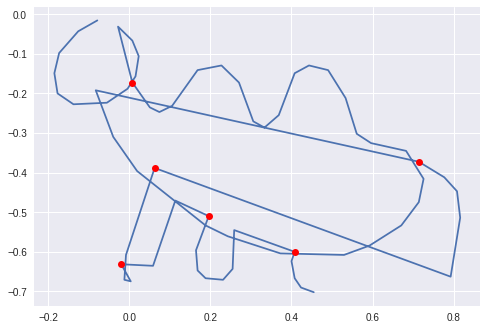

In [0]:
# Visualize / control output of dict_to_stroke().

stroke = dict_to_stroke(sample[0])
# First 2 dimensions are normalized dx/dy coordinates
# third dimension indicates "new stroke".
xy = stroke[:2, :].cumsum(axis=1)
pyplot.plot(xy[0,:], -xy[1,:])
pxy = xy[:, stroke[2] != 0]
# Indicate "new stroke" with a red circle.
pyplot.plot(pxy[0], -pxy[1], 'ro');

In [0]:
# Uses dict_to_stroke() from previous cell to create raster image.

def make_example_stroke(label, drawing):
  """Converts QuickDraw dictionary to example with stroke data.

  Args:
    label: Numerical representation of the label (e.g. "0" for labels[0]).
    drawing: Dictionary with QuickDraw data.

  Returns:
    A tf.train.Example protocol buffer (with "label", "stroke_x", "stroke_y",
    "stroke_z", and additional metadata features).
  """
  example = tf.train.Example()
  example.features.feature['label'].int64_list.value.append(label)
  stroke = dict_to_stroke(drawing)
  example.features.feature['stroke_x'].float_list.value.extend(stroke[0, :])
  example.features.feature['stroke_y'].float_list.value.extend(stroke[1, :])
  example.features.feature['stroke_z'].float_list.value.extend(stroke[2, :])
  example.features.feature['stroke_len'].int64_list.value.append(stroke.shape[1])
  example.features.feature['countrycode'].bytes_list.value.append(drawing['countrycode'].encode())
  example.features.feature['recognized'].int64_list.value.append(drawing['recognized'])
  example.features.feature['word'].bytes_list.value.append(drawing['word'].encode())
  ts = drawing['timestamp']
  ts = time.mktime(time.strptime(ts[:ts.index('.')], '%Y-%m-%d %H:%M:%S'))
  example.features.feature['timestamp'].int64_list.value.append(int(ts))
  example.features.feature['key_id'].int64_list.value.append(int(drawing['key_id']))
  return example

In [0]:
path = '%s/%s_stroke' % (data_path, dataset_name)
t0 = time.time()
examples_per_split = make_sharded_files(
    make_example=make_example_stroke,
    path=path,
    labels=labels,
    iters=[loaditer(name) for name in labels],
    # Creating 50k train, 10k eval, 20k test examples. Takes ~2min
    # Note : You can improve 
    counts=make_counts(labels, 80000),
    splits=dict(train=5, eval=1, test=2),
    overwrite=True,
    # Note : Set this to False when generating large datasets...
    make_df=True,
)

print('stored data to "%s"' % path)
print('generated %s examples in %d seconds' % (examples_per_split, time.time() - t0))

processed 15877/80000 (19.85%)
processed 30275/80000 (37.84%)
processed 47088/80000 (58.86%)
processed 60651/80000 (75.81%)
processed 75714/80000 (94.64%)
Writing /content/gdrive/My Drive/amld_data/zoo_stroke/dataframe.pkl...
stored data to "/content/gdrive/My Drive/amld_data/zoo_stroke"
generated {'eval': 10000, 'test': 20000, 'train': 50000} examples in 69 seconds


# ----- Optional part -----

## Inspect data

In [0]:
# YOUR ACTION REQUIRED:
# Check out the files generated in $data_path

# Note that you can also inspect the files in http://drive.google.com if you
# used Drive as the destination.
#--snip
!ls -lh "$data_path"/"$dataset_name"*

'/content/gdrive/My Drive/amld_data/zoo_img':
total 2.9G
-rw------- 1 root root   46 Jan 25 23:11 counts.json
-rw------- 1 root root 2.5G Jan 25 23:14 dataframe.pkl
-rw------- 1 root root 5.1M Jan 25 23:11 eval-00000-of-00010
-rw------- 1 root root 5.1M Jan 25 23:11 eval-00001-of-00010
-rw------- 1 root root 5.1M Jan 25 23:11 eval-00002-of-00010
-rw------- 1 root root 5.1M Jan 25 23:11 eval-00003-of-00010
-rw------- 1 root root 5.1M Jan 25 23:11 eval-00004-of-00010
-rw------- 1 root root 5.1M Jan 25 23:11 eval-00005-of-00010
-rw------- 1 root root 5.1M Jan 25 23:11 eval-00006-of-00010
-rw------- 1 root root 5.1M Jan 25 23:11 eval-00007-of-00010
-rw------- 1 root root 5.1M Jan 25 23:11 eval-00008-of-00010
-rw------- 1 root root 5.1M Jan 25 23:11 eval-00009-of-00010
-rw------- 1 root root   89 Jan 25 23:11 labels.txt
-rw------- 1 root root  11M Jan 25 23:11 test-00000-of-00010
-rw------- 1 root root  11M Jan 25 23:11 test-00001-of-00010
-rw------- 1 root root  11M Jan 25 23:11 test-00002

In [0]:
# Let's look at a single file of the sharded dataset.
tf_record_path = '{}/{}_img/eval-00000-of-00010'.format(data_path, dataset_name)
# YOUR ACTION REQUIRED:
# Use tf.python_io.tf_record_iterator() to read a single record from the file
# an assign it to the variable "record".
# What datatype has this record?
#record = ...
#record
#--snip
for record in tf.python_io.tf_record_iterator(tf_record_path):
  break
# Efficient binary encoding of the protocol buffer.
record

b"\n\xfe'\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\t\n\x13\n\x04word\x12\x0b\n\t\n\x07penguin\n\x16\n\ttimestamp\x12\t\x1a\x07\n\x05\xcb\x96\xf4\xc6\x05\n\x16\n\x06key_id\x12\x0c\x1a\n\n\x08\x80\x80\x80\x87\xea\x8c\xbc\t\n\x13\n\nrecognized\x12\x05\x1a\x03\n\x01\x01\n\xfa&\n\x06img_64\x12\xef&\x1a\xec&\n\xe9&\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\x01\xff\x01\xff\x01\xff

**Note**: 
The `tf.python_io` should only be used for data processing in pure  Python. For machine learning applications you should instead use the `tf.data.Dataset` interface (see `2_keras.ipynb`). This has the advantage that the underlying file reading and protobuf parsing operations can be translated into TensorFLow Ops and implemented efficiently without passing the data through the Python kernel.



In [0]:
# Check out the features. They should correspond to what we generated in
# make_example_img() above.
example = tf.train.Example()
example.ParseFromString(record)
print(list(example.features.feature.keys()))

['timestamp', 'key_id', 'recognized', 'img_64', 'countrycode', 'word', 'label']


In [0]:
# YOUR ACTION REQUIRED:
# Extract the label and the image data from the example protobuf.
# (use above section "tf.train.Example" for reference).
label_int = example.features.feature['label'].int64_list.value[0]  #label_int =
img_64 = example.features.feature['img_64'].int64_list.value  #img_64 = 

penguin


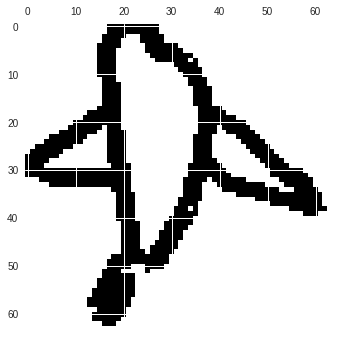

In [0]:
# Visualize the image:
print(labels[label_int])
pyplot.matshow(np.array(img_64).reshape((64, 64)));

[9, 7, 4, 2, 8, 4, 4, 3, 2, 8, 3, 8, 7, 4, 8, 10, 10, 0, 4, 4, 7, 5, 1, 8, 5, 1, 1, 1, 0, 0, 1, 8, 3, 9, 1, 3, 9, 4, 4, 8, 5, 4, 9, 5, 8, 0, 6, 9, 8, 9, 4, 0, 8, 3, 5, 10, 0, 2, 4, 6, 3, 10, 2, 10, 9, 5, 0, 7, 1, 3, 7, 8, 6, 3, 9, 9, 2, 9, 9, 1, 6, 6, 7, 5, 3, 6, 1, 4, 10, 1, 1, 10, 5, 7, 1, 0, 9, 6, 0, 6]


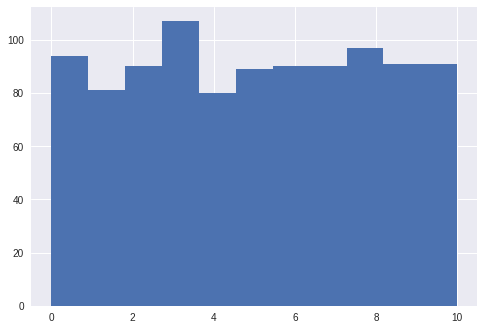

In [0]:
# YOUR ACTION REQUIRED:
# Check that we have an equal distribution of labels in the training files.
#--snip
sample = []
for i, record in enumerate(tf.python_io.tf_record_iterator(tf_record_path)):
  example = tf.train.Example()
  example.ParseFromString(record)
  sample.append(example.features.feature['label'].int64_list.value[0])
  if i == 10000: break
pyplot.hist(sample, bins=len(labels))
print(sample[:100])

## More on protobufs

In [0]:
# If we want to create our own protocol buffers, we first need to install
# some programs...
!apt-get -y install protobuf-compiler python-pil python-lxml

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pil is already the newest version (5.1.0-1).
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [0]:
# Step 1 : Write a proto file that describes our data format.
# YOUR ACTION REQUIRED: Complete the definition of the "Person" message (you
# can use the slide for inspiration).
with open('person.proto', 'w') as f:
  f.write('''
      syntax = "proto2";
  ''')
#--snip
  f.write('''
      message Person {////
        optional string name = 1;////
        optional string email = 2;////
        repeated int32 lucky_numbers = 3;////
      }
  ''')

In [0]:
# Step 2 : Compile proto definition to a Python file.
!protoc --python_out=. person.proto
!ls -lh

total 16K
drwx------ 4 root root 4.0K Jan 25 23:05 gdrive
-rw-r--r-- 1 root root 2.5K Jan 25 23:15 person_pb2.py
-rw-r--r-- 1 root root  189 Jan 25 23:15 person.proto
drwxr-xr-x 1 root root 4.0K Jan  8 17:15 sample_data


In [0]:
# Step 3 : Import code from generated Python file.
from person_pb2 import Person

In [0]:
person = Person()
person.name = 'John Doe'
person.email = 'john.doe@gmail.com'
person.lucky_numbers.extend([13, 99])
person.SerializeToString()

b'\n\x08John Doe\x12\x12john.doe@gmail.com\x18\r\x18c'

In [0]:
# YOUR ACTION REQUIRED:
# Compare the size of the serialized person structure in proto format
# vs. JSON encoded (you can use Python's json.dumps() and list members
# manually, or import google.protobuf.json_format).

# Which format is more efficient? Why?
# Which format is easier to use?
# Which format is more versatile?
#--snip
import json
print(len(person.SerializeToString()))
from google.protobuf.json_format import MessageToJson
len(MessageToJson(person))

34


97